# Computing Graphs and initial conditions

This notebook will instatiate and save the necessities for conducting the dynamical analysis.
Firstly the dataset will be elaborated and then graphs and initial conditions will be computed.
Might be necessary to change the data path (`PATH_TO_DATA`) or the dataset filnames (`WORD_VECTORS_FILENAME` and `ARTCLES_DF_FILENAME`).

In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from sklearn.preprocessing import normalize
from gensim.models.word2vec import KeyedVectors
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
# import cugraph ## this library works with CUDA-capable GPUs but has many issues

PATH_TO_DATA = Path('../data')
WORD_VECTORS_FILENAME = 'words_dataframe.csv'
ARTICLES_DF_FILENAME = 'info_dataframe.csv'
N_THREADS = 12
MIN_SIM=0.5

## Create Similarity Matrix

In order to create the **Similarity Matrix**, we should _load_ the 'WORD VECTORS' DataFrame and then we should _calculate the distances_ of all the articles (exploiting the simple dot product).
'WORD_VECTORS' must be passed through the `create_model_matrix` function that will map each document to its 300-dim vector representation using a model from `gensim`.
This model can be dowloaded using the downloading API of `gensim`, more information can be found [here](https://github.com/RaRe-Technologies/gensim-data).
The available models to choose are [ConceptNet Numberbatch](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/view/14972) or [Google News Word2Vec](https://code.google.com/archive/p/word2vec/).

The results of `create_model_matrix` must be normalized before computing the distance.
The fastest method for normalization is that from _sklearn_, but also a _numpy_ version is provided (but not used).

This is equivalent to use the _cosine similarity_ distance to compute these distances.

Loading the DataFrame is the first thing to do.

In [2]:
# Load the dataframe
word_vectors = pd.read_csv(PATH_TO_DATA/WORD_VECTORS_FILENAME).drop(['Unnamed: 0','article_id'], 1)
# get all the possible words
all_words = list(word_vectors.columns)
word_vectors

,igor,flag,few,repeat,confeder,drill,januari,bobic,situat,parti,...,sisk,klfi,thurman,bronlynn,gar,ujima,wksu,wkyc,akron,artsnow
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2988,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Then, the function for creating the whole word matrix is defined, TFITF score is used as weight.

In [12]:
def create_model_matrix(data, model):

    # instatiate the iterator
    articles_iterator = tqdm(
        range(len(data)),
        leave=False,
        unit='articles',
    )

    # function to parallelize 
    def fn(article):
        article_vector = np.zeros((1, 300))
        for i, word in enumerate(all_words):
            # using tf-idf as weight
            tf = data[article,i]
            n = np.sum(data[:,i])
            idtf = np.log(len(data)/n)
            weight = tf*idtf
            try:
                word_vector = model.get_vector(word)
                try:
                    assert np.isfinite(word_vector).all()
                except AssertionError:
                    print(w)
            except KeyError:
                word_vector = np.zeros((1, 300))
            article_vector = article_vector + word_vector*weight
        return article_vector
            
    list_of_docvs = Parallel(n_jobs=N_THREADS)(delayed(fn)(i) for i in articles_iterator)
    return np.array(list_of_docvs).squeeze()

Loading the [ConceptNet Numberbatch](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/view/14972) model, and adapting to our words.

In [4]:
conceptnet = KeyedVectors.load_word2vec_format(PATH_TO_DATA/'conceptnet-numberbatch-17-06-300.gz')
conceptnet = conceptnet.vectors_for_all(all_words)
conceptnet

Loading the [Google News Word2Vec](https://code.google.com/archive/p/word2vec/) model, and adapting to our words.

In [5]:
google_news_word2vec = KeyedVectors.load_word2vec_format(PATH_TO_DATA/'word2vec-google-news-300.gz', binary=True)
google_news_word2vec = google_news_word2vec.vectors_for_all(all_words)
google_news_word2vec

Get the whole word matrix using the DataFrame and the model choosen. 

In [13]:
# ~1h computations
model = conceptnet
conceptnet_docvs = create_model_matrix(np.array(word_vectors), model)
np.savez(PATH_TO_DATA/'conceptnet_docvs.npz', conceptnet_docvs)
conceptnet_docvs.shape

  0%|          | 0/2992 [00:00<?, ?articles/s]

(2992, 300)

In [14]:
# ~1h20min computations
model = google_news_word2vec
google_docvs = create_model_matrix(np.array(word_vectors), model)
np.savez(PATH_TO_DATA/'google_docvs.npz', google_docvs)
google_docvs.shape

  0%|          | 0/2992 [00:00<?, ?articles/s]

(2992, 300)

In [17]:
#docvs = conceptnet_docvs
docvs = google_docvs
docvs

array([[-4.15124185e+00,  8.49358914e+00,  3.24921606e+00, ...,
        -7.54261422e+00,  4.95666061e+00, -2.39626000e+00],
       [ 2.14510083e+01,  3.21642291e+01,  5.47439096e+00, ...,
        -3.59560750e+01,  1.89494194e+01,  8.06504266e-01],
       [-2.01376798e+01,  5.91221505e+01,  1.30303238e+02, ...,
        -5.36260845e+01, -7.60163316e+00,  1.79734167e+02],
       ...,
       [-1.39637447e+01,  2.76800045e+01, -9.91592173e-02, ...,
        -2.79628069e+01, -1.12852966e+01,  1.77993376e+01],
       [-4.35520784e+00,  5.69531574e+00,  6.75323993e+00, ...,
        -6.08904045e+00,  2.29433093e+00,  1.00694237e+01],
       [-8.89013666e+00,  6.28166851e+00, -5.81385224e+00, ...,
        -4.23384561e+00, -3.51962592e+00, -5.14883912e-01]])

`numpy` normalization procedure.

In [18]:
# Alternative normalization procedure
row_sums = docvs.sum(axis=1)
np_docvs_norm = (docvs / np.sqrt((docvs ** 2).sum(-1))[..., np.newaxis]).astype('float')
print("Shape of normalized matrix is {}.".format(np_docvs_norm.shape))
print("Sum of normalized matrix is {}.".format(np.sum(np_docvs_norm)))
print("Max={}; Min={}.".format(np.max(np_docvs_norm), np.min(np_docvs_norm)))
np.savez(PATH_TO_DATA/'np_docvs_norm.npz', np_docvs_norm)
np_docvs_norm.shape

Shape of normalized matrix is (2992, 300).
Sum of normalized matrix is -2821.8530565127417.
Max=0.26247709861429375; Min=-0.24015063773379133.


(2992, 300)

`sklearn` normalization procedure (axis=1).

In [ ]:
# Scikit-learn normalization procedure (axis=1)
sk_docvs_norm = normalize(docvs)
print("Shape of normalized matrix is {}.".format(sk_docvs_norm.shape))
print("Sum of normalized matrix is {}.".format(np.sum(sk_docvs_norm)))
print("Max={}; Min={}.".format(np.max(sk_docvs_norm), np.min(sk_docvs_norm)))
np.savez(PATH_TO_DATA/'sk_docvs_norm.npz', sk_docvs_norm)
sk_docvs_norm.shape

Shape of normalized matrix is (2992, 300).
Sum of normalized matrix is -2821.8530565127417.
Max=0.2624770986142937; Min=-0.24015063773379128.


(2992, 300)

`sklearn` normalization procedure (axis=0).

In [ ]:
# Scikit-learn normalization procedure (axis=0)
sk_docvs_norm_0 = normalize(docvs, axis=0)
print("Shape of normalized matrix is {}.".format(sk_docvs_norm_0.shape))
print("Sum of normalized matrix is {}.".format(np.sum(sk_docvs_norm_0)))
print("Max={}; Min={}.".format(np.max(sk_docvs_norm_0), np.min(sk_docvs_norm_0)))
np.savez(PATH_TO_DATA/'sk_docvs_norm_0.npz', sk_docvs_norm_0)
sk_docvs_norm_0.shape

Shape of normalized matrix is (2992, 300).
Sum of normalized matrix is -385.42704597643336.
Max=0.7677907488628147; Min=-0.7839928123377826.


(2992, 300)

Computation of the distance matrix.
The simple dot product is used between the matrix and its transpose.
Here are used `scipy.sparse` matrices.

In [ ]:
s = sparse.csr_matrix(sk_docvs_norm_0)
s_t = sparse.csr_matrix(sk_docvs_norm_0).T
s_dist = s.dot(s_t)
dists_triu = sparse.triu(s_dist, k=1)
dists_triu = np.array(dists_triu.todense())
np.savetxt(PATH_TO_DATA/'dists_triu.csv', dists_triu, delimiter=',')
dists_triu

array([[0.        , 0.00308819, 0.00696101, ..., 0.00255968, 0.00131486,
        0.00156821],
       [0.        , 0.        , 0.01373176, ..., 0.00648343, 0.00526058,
        0.00366223],
       [0.        , 0.        , 0.        , ..., 0.02528784, 0.01349776,
        0.00650302],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00369467,
        0.00284467],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00184842],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
dists = np.dot(np_docvs_norm, np_docvs_norm.T).astype('float')
dists_triu = np.triu(dists, k=1)
np.savetxt('../data/dists_triu.csv', dists_triu, delimiter=',')
print("Shape of similarity matrix is {}.".format(dists_triu.shape))
print("Sum of similarity matrix is {}.".format(np.sum(dists_triu)))
print("Max={}; Min={}.".format(np.max(dists_triu), np.min(dists_triu)))
dists_triu

Shape of similarity matrix is (2992, 2992).
Sum of similarity matrix is 2725212.7520491164.
Max=1.0000000000000004; Min=-0.4190984022529244.


array([[0.        , 0.71497394, 0.50444967, ..., 0.66298975, 0.61015226,
        0.65692472],
       [0.        , 0.        , 0.46490303, ..., 0.64113891, 0.7083136 ,
        0.63537908],
       [0.        , 0.        , 0.        , ..., 0.57545389, 0.56454262,
        0.46803413],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.65108241,
        0.57432244],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.59058211],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

These methods, used for building the graph, have been extracted and adapted from [this repo](https://github.com/elisamussumeci/modeling-news-spread).

In [54]:
def get_index(data, timestamp, similarities, max_dt, min_similarity, outs):
    while True:
        # get the maximum similarity w.r.t. older articles
        similarity = max(similarities)
        # get the index of such max similar article
        index = similarities.index(similarity)
        # get dt in terms of hours
        dt = (timestamp - data['timestamp'][index]).total_seconds() / 3600
        # similarity threshold
        if similarity < min_similarity:
            # return None to add index to outs
            return None
        # continue if article is in outs or its distant in time
        elif index in outs or dt > max_dt:
            similarities[index] = 0
        # pass condition
        else:
            return index

def create_graph(
    dists_triu, # similarity matrix
    data, # DataFrame containing articles info
    time_max: int = 168, # max dt (in hours) for two articles to be linked
    sim_min: float = 0.8, # minimum cos sim distance for two articles to be linked
    ):
    # max number of nodes
    n_articles = dists_triu.shape[0]
    # instantiate the directed graph
    G = nx.DiGraph()
    # adding the first node
    G.add_node(0, step=0,
               date=data['timestamp'][0],
               domain=data['source'][0],
               _id=data['article_id'][0],
               children=[])
    # instatiating elimination list
    outs = []
    # loop on the other articles
    for i in range(1, n_articles):
        # get time of current article
        pub_i = data['timestamp'][i]
        # get similarities
        column = list(dists_triu[:, i])
        # get index of an article related to the current one
        index = get_index(data, pub_i, column, time_max, sim_min, outs)
        # if a relation was found
        if index != None:
            # if the related article has not already been inserted, insert it
            if index not in G.nodes():
                G.add_nodes_from([(index, {
                    'timestamp': data['timestamp'][index],
                    'source': data['source'][index],
                    'id': data['article_id'][index],
                })])
            # if the current article has not already been inserted, insert it
            if i not in G.nodes():
                G.add_nodes_from([(i, {
                    'timestamp': data['timestamp'][i],
                    'source': data['source'][i],
                    'id': data['article_id'][i]
                })])
            # linking the nodes
            G.add_edge(index, i)
        # if a relation wa not found
        else:
            # add current article to elimination listS
            outs.append(i)
    # return the graph
    return G

def create_date(pub1, pub2, s):
    dif = (pub2-pub1).total_seconds()/3600
    return round((dif/s))

def create_graphml(dists_triu, data, time_max=168, sim_min=0.8):
    size = dists_triu.shape[0]
    G = nx.DiGraph()
    G.add_node(0, step=0, date=0, domain=data['source'][0])
    date_init = data['timestamp'][0]
    outs = []
    for i in range(1, size):
        pub_i = data['timestamp'][i]
        column = list(dists_triu[:,i])
        pos = get_pos(data, pub_i, column, time_max, sim_min, outs)

        if pos != None:
            if pos not in G.nodes():
                domain_1 = data['source'][pos]
                date_1 = create_date(date_init, data['timestamp'], 5)
                G.add_node(pos, date=date_1, domain=domain_1)
            if i not in G.nodes():
                domain_2 = data['source'][i]
                date_2 = create_date(date_init, pub_i, 5)
                G.add_node(i, date=date_2, domain=domain_2)

            G.add_edge(pos, i)
        else:
            outs.append(i)
    return G

def create_matrix_domain(graph):
    
    domain_list = []
    for pos in graph.nodes():
        node = graph.nodes()[pos]
        d = node['domain']
        if d not in domain_list:
            domain_list.append(d)

    df = pd.DataFrame(0, index = domain_list, columns = domain_list)

    for pos in graph.nodes():
        node = graph.nodes()[pos]
        d = node['domain']
        successors = graph.successors(pos)
        for suc in successors:
            df[d][graph.nodes()[suc]['domain']] += 1

    return [domain_list, df]

def create_complete_adjacency(graph, matrix):
    df = pd.DataFrame(0, index=graph.nodes(), columns=graph.nodes())
    for column in graph.nodes():
        i_domains_column = matrix[graph.nodes()[column]['domain']]
        for row in graph.nodes():
            prob = i_domains_column[graph.nodes()[row]['domain']]
            df[column][row] = prob

    return df

Creating, saving and drawing the Graphs instatiated using _networkX_ library.

In [21]:
articles = pd.read_csv(PATH_TO_DATA/ARTICLES_DF_FILENAME)
articles['timestamp'] = pd.to_datetime(articles.timestamp)
articles = articles.drop('Unnamed: 0', 1)
articles = articles.rename(columns={'id': 'article_id'})
articles

,article_id,timestamp,source
0,1816056005,2021-01-06,537508
1,1816132855,2021-01-06,4452
2,1816195886,2021-01-06,267703
3,1816238212,2021-01-06,100063
4,1816336438,2021-01-06,23539
...,...,...,...
2987,1843892109,2021-02-05,38907
2988,1843827906,2021-02-05,368186
2989,1843729662,2021-02-05,157349
2990,1843976290,2021-02-05,158115


In [55]:
G = create_graph(dists_triu, articles, sim_min=MIN_SIM)

In [59]:
G.nodes()._nodes

{0: {'step': 0,
  'date': Timestamp('2021-01-06 00:00:00'),
  'domain': 537508,
  '_id': 1816056005,
  'children': []},
 1: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 4452,
  'id': 1816132855},
 2: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 267703,
  'id': 1816195886},
 3: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 100063,
  'id': 1816238212},
 4: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 23539,
  'id': 1816336438},
 5: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 336377,
  'id': 1816337284},
 6: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 29410,
  'id': 1816878238},
 7: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 39470,
  'id': 1816358656},
 8: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 623377,
  'id': 1816369068},
 9: {'timestamp': Timestamp('2021-01-06 00:00:00'),
  'source': 90123,
  'id': 1816389651},
 10: {'timestamp': Timestamp('2021-01-06 00:00:00

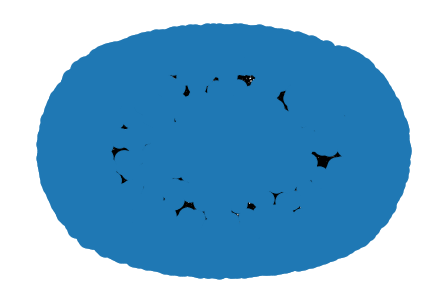

In [48]:

nx.draw(G)#, with_labels=True, font_weight='bold')

In [22]:
G = create_graph(dists_triu, articles, sim_min=MIN_SIM)
nx.write_gpickle(G, PATH_TO_DATA/'empirical_graph.gpickle')
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()
H = create_graphml(dists_triu, articles, sim_min=MIN_SIM)
nx.write_graphml(H, PATH_TO_DATA/'empirical_graph.graphml')
# nx.draw(H, with_labels=True, font_weight='bold')

In [40]:
H.nodes(4)._data

4

In [ ]:
pd.DataFrame(dict(G.nodes())).transpose().to_csv(PATH_TO_DATA/'empirical_graph_nodes.csv')
all_nodes_domains = []
for i in G.nodes():
    all_nodes_domains.append(G.nodes()[i]['domain'])

f = open(PATH_TO_DATA/'graph_original_domains_each_node.txt', 'w')
for item in all_nodes_domains:
    f.write("%s\n" % item)

In [ ]:
domain_list, domain_matrix = create_matrix_domain(G)
graph_complete = create_complete_adjacency(G, domain_matrix)
as_numpy = np.array(graph_complete)
np.fill_diagonal(as_numpy, 0)
np.savetxt(PATH_TO_DATA/'graph_complete.csv', as_numpy, delimiter=',')
graph_complete

,0,1,2,3,4,5,6,7,8,9,...,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Methods for initializing the dynamic simulation and creating the initial state.

In [ ]:
def create_first_pubs(original_graph):
    dates_list = [original_graph.nodes()[node]['date'] for node in original_graph.nodes()]
    fs = []
    print(min(dates_list).date())
    for node in original_graph.nodes():
        if original_graph.nodes()[node]['date'].date() == min(dates_list).date():
            fs.append(original_graph.nodes()[node]['domain'])
    return fs


def create_i0(list_first_pubs, domains):
    i0 = np.zeros(len(domains))
    for pos, i in enumerate(i0):
        if domains[pos] in list_first_pubs:
            i0[pos] = 1
            list_first_pubs.remove(domains[pos])

    return i0

Initialization

In [ ]:
list_first_pubs = create_first_pubs(G)
len(list_first_pubs)

2021-01-06


197

In [ ]:
I0 = create_i0(list_first_pubs, all_nodes_domains)
np.savetxt(PATH_TO_DATA/'i0.csv', I0, delimiter=',')
print('The number of inital infected is {}'.format(np.sum(I0)))
I0

The number of inital infected is 197.0


array([1., 1., 1., ..., 0., 0., 0.])